### Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRFRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform 


### Data Loading

In [4]:
data = pd.read_csv("car_insurance_claim.csv")

In [5]:
data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [7]:
data.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE',
       'CLAIM_FLAG', 'URBANICITY'],
      dtype='object')

In [8]:
data.describe()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE,CLAIM_FLAG
count,1.030200e+04,10302.000000,10295.000000,10302.000000,9754.000000,10302.000000,10302.000000,10302.000000,10302.000000,9663.000000,10302.000000
mean,4.956631e+08,0.169288,44.837397,0.720443,10.474062,33.416424,5.329159,0.800718,1.710153,8.298148,0.266550
std,2.864675e+08,0.506512,8.606445,1.116323,4.108943,15.869687,4.110795,1.154079,2.159015,5.714450,0.442177
min,6.317500e+04,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000,0.000000
25%,2.442869e+08,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.970043e+08,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000,0.000000
75%,7.394551e+08,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000,1.000000
max,9.999264e+08,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000,1.000000


### Data Cleaning

In [9]:
# Rename columns
col_names = {
    "KIDSDRIV" : "n_young_drivers",
    "BIRTH" : "date_of_birth",
    "AGE" : "age",
    "HOMEKIDS" : "n_children",
    "YOJ" : "year_of_jobs",
    "INCOME" : "income",
    "PARENT1" : "single_parent",
    "HOME_VAL" : "home_value",
    "MSTATUS" : "married",
    "GENDER" : "gender",
    "EDUCATION" : "highest_education",
    "OCCUPATION" : "occupation",
    "TRAVTIME" : "commute_dist",
    "CAR_USE" : "type_of_use",
    "BLUEBOOK" : "vehicle_values",
    "TIF" : "policy_tenure",
    "CAR_TYPE" : "car_type",
    "RED_CAR" : "red_vehicle",
    "OLDCLAIM" : "5_year_claim_value",
    "CLM_FREQ" : "5_year_num_claim",
    "REVOKED" : "license_revoked",
    "MVR_PTS" : "license_points",
    "CLM_AMT" : "new_claim_value",
    "CAR_AGE" : "vehicle_age",
    "CLAIM_FLAG": "is_claim",
    "URBANICITY" : "address_type",
}

data.rename(columns=col_names, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  10302 non-null  int64  
 1   n_young_drivers     10302 non-null  int64  
 2   date_of_birth       10302 non-null  object 
 3   age                 10295 non-null  float64
 4   n_children          10302 non-null  int64  
 5   year_of_jobs        9754 non-null   float64
 6   income              9732 non-null   object 
 7   single_parent       10302 non-null  object 
 8   home_value          9727 non-null   object 
 9   married             10302 non-null  object 
 10  gender              10302 non-null  object 
 11  highest_education   10302 non-null  object 
 12  occupation          9637 non-null   object 
 13  commute_dist        10302 non-null  int64  
 14  type_of_use         10302 non-null  object 
 15  vehicle_values      10302 non-null  object 
 16  poli

In [11]:
# Check for duplicate rows 
data.duplicated().sum()


1

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
# data.dropna(axis=0, inplace=True)

In [14]:
currency_col = ['income', 'home_value', 'vehicle_values', '5_year_claim_value', 'new_claim_value']

# Remove $ symbols on those columns
def remove_currency(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype("Int64")
    return data

data = remove_currency(data, currency_col)

In [15]:
# Remove z_ prefix
def remove_prefix(data):
    data = data.replace('[z_]', '', regex=True)
    return data

data = remove_prefix(data)

In [17]:
((data['new_claim_value'] > 0) & (data['is_claim'] == 0)).sum()

0

In [18]:
data.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [19]:
data.head()

,n_young_drivers,age,n_children,year_of_jobs,income,single_parent,home_value,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_values,policy_tenure,car_type,red_vehicle,5_year_claim_value,5_year_num_claim,license_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


<Axes: xlabel='new_claim_value', ylabel='Count'>

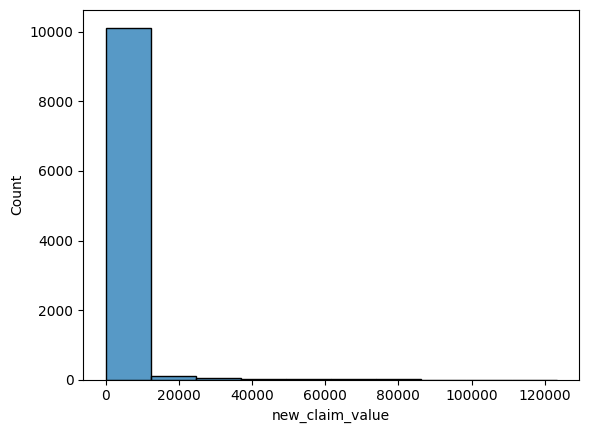

In [20]:
sns.histplot(data['new_claim_value'], bins=10)

In [45]:
# Define the bins
bins = np.arange(0, 50000+1, 5000).astype(float).tolist()
bins.append(np.inf)

# Define bins label
labels = np.arange(1, 12)

# Apply the bins
data['claim_value_cat'] = pd.cut(data['new_claim_value'], bins=bins, labels=labels, include_lowest=True )

<Axes: ylabel='claim_value_cat'>

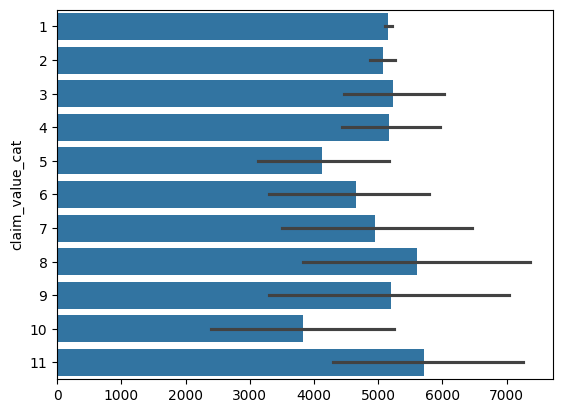

In [46]:
# Show distribution with bar plot
sns.barplot(data['claim_value_cat'])